In [4]:
import matplotlib.pyplot as plt
import datajoint as dj
import numpy as np

import seaborn as sns
import pandas as pd
from DMS2_utils import *
from DMS2_fetch_protocol_data import *

# settings
%load_ext autoreload
%autoreload 2
dj.blob.use_32bit_dims = True # necessary for pd.blob read
sns.set_context("talk")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# ANIMAL_IDS = ["R610", "R611", "R612", "R613", "R614"]
# ANIMAL_ID = "R611"
# SESSION = 911940
# bdata = dj.create_virtual_module("bdata", "bdata")

In [5]:
df = fetch_latest_training_data()

fetched 3 sessions for R610 between 2023-04-13 and 2023-04-16
fetched 3 sessions for R611 between 2023-04-13 and 2023-04-16
fetched 3 sessions for R612 between 2023-04-13 and 2023-04-16
fetched 3 sessions for R613 between 2023-04-13 and 2023-04-16
fetched 3 sessions for R614 between 2023-04-13 and 2023-04-16


In [6]:
make_daily_spoke_stage_plot(df)

plotting for R610
plotting for R611
plotting for R612
plotting for R613
plotting for R614
plotting for R610
plotting for R611
plotting for R612
plotting for R613
plotting for R614
plotting for R610
plotting for R611
plotting for R612
plotting for R613
plotting for R614


## Figures in progress below

In [16]:
for (date, animal_id), sub_df in df.groupby(['date','animal_id']):
    None

In [20]:
date, animal_id

(datetime.date(2023, 4, 15), 'R614')

In [33]:
sub_df.date.iloc[0]

datetime.date(2023, 4, 15)

In [152]:
def plot_daily_result_summary(df, ax, title=""):
    """
    TODO
    """
    res_summary = df.result.value_counts(normalize=True).sort_values()
    res_summary.plot(kind="bar", color=get_result_colors(df.result), ax=ax)
    
    _ = ax.bar_label(ax.containers[0],fontsize=12, fmt='%.2f')
    
    ax.set(ylim=(0,1),ylabel="Proportion",title=title)


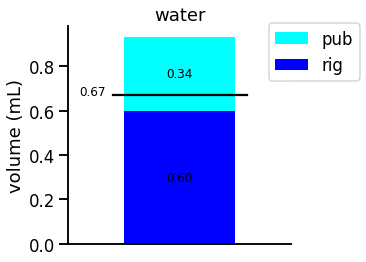

In [166]:
fig,ax = plt.subplots(figsize=(4,4))
plot_daily_water(sub_df, ax,title= "water")

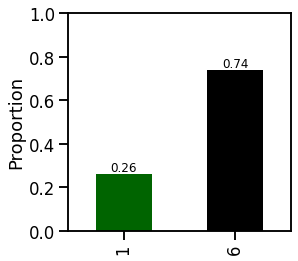

In [153]:
fig,ax = plt.subplots(figsize=(4,4))

plot_daily_result_summary(sub_df, ax, title="")

In [45]:
sub_df

,trial,animal_id,date,sess_id,result,hits,violations,temperror,hit_rate,error_rate,...,give_water_not_drunk,crash_hist,l_water_vol,r_water_vol,ab_l_prob,ab_r_prob,ab_beta,ab_tau,sound_pair,was_no_answer
50,1,R614,2023-04-15,912139,6,<NA>,<NA>,<NA>,0.0,0.0,...,True,False,20.0,20.0,0.0,1.0,0.0,30.0,"12.0, 3.0",True
51,2,R614,2023-04-15,912139,6,<NA>,<NA>,<NA>,NaN,NaN,...,True,False,20.0,20.0,0.0,1.0,0.0,30.0,"3.0, 12.0",True
52,3,R614,2023-04-15,912139,1,1,0,0,NaN,NaN,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"3.0, 12.0",NaN
53,4,R614,2023-04-15,912139,6,<NA>,<NA>,<NA>,1.0,0.0,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"3.0, 12.0",True
54,5,R614,2023-04-15,912139,6,<NA>,<NA>,<NA>,1.0,0.0,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"3.0, 12.0",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,61,R614,2023-04-15,912139,6,<NA>,<NA>,<NA>,1.0,0.0,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"3.0, 12.0",True
111,62,R614,2023-04-15,912139,1,1,0,0,1.0,0.0,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"12.0, 3.0",NaN
112,63,R614,2023-04-15,912139,1,1,0,0,1.0,0.0,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"12.0, 3.0",NaN
113,64,R614,2023-04-15,912139,6,<NA>,<NA>,<NA>,1.0,0.0,...,False,False,20.0,20.0,0.0,1.0,0.0,30.0,"3.0, 12.0",True


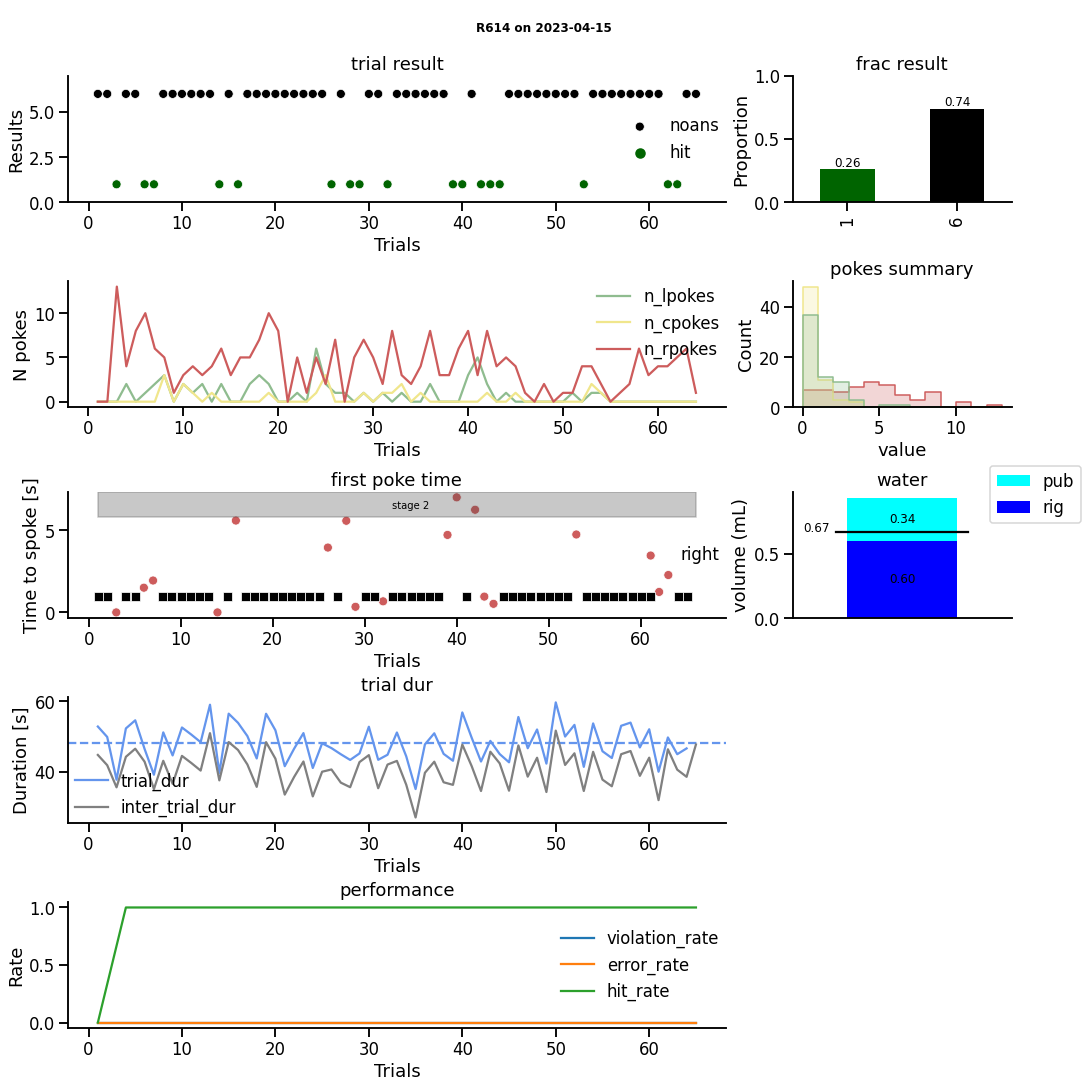

In [169]:
layout= """
    AAAB
    CCCD
    EEEF
    GGG.
    HHH.
"""
fig = plt.figure(constrained_layout=True,figsize=(15,15))

plt.suptitle(f"\n{animal_id} on {date}\n", fontweight="semibold")
ax_dict = fig.subplot_mosaic(layout) #ax to plot to

plot_daily_results(sub_df,ax=ax_dict['A'], title="trial result")
plot_daily_result_summary(sub_df, ax=ax_dict['B'], title="frac result")
plot_daily_npokes(sub_df,ax_dict['C'], plot_stage_info=False)
plot_pokes_hist(sub_df, ax_dict['D'], title="pokes summary")
plot_daily_first_spoke(sub_df, ax_dict['E'], title="first poke time",plot_stage_info=True)
plot_daily_water(sub_df, ax_dict['F'], title= "water")
plot_daily_trial_dur(sub_df, ax_dict['G'], title="trial dur")
plot_daily_perfs(sub_df, ax_dict['H'], title="performance")

    

In [212]:
make_daily_spoke_stage_plot(df, overwrite=True)

plotting for R610
plotting for R611
plotting for R612
plotting for R613
plotting for R614


R610_2023-04-13_daily_spoke_stage.png
plotting for R610
R611_2023-04-13_daily_spoke_stage.png
plotting for R611
R612_2023-04-13_daily_spoke_stage.png
plotting for R612
R613_2023-04-13_daily_spoke_stage.png
plotting for R613
R614_2023-04-13_daily_spoke_stage.png
plotting for R614


<AxesSubplot:label='D', xlabel='value', ylabel='Count'>

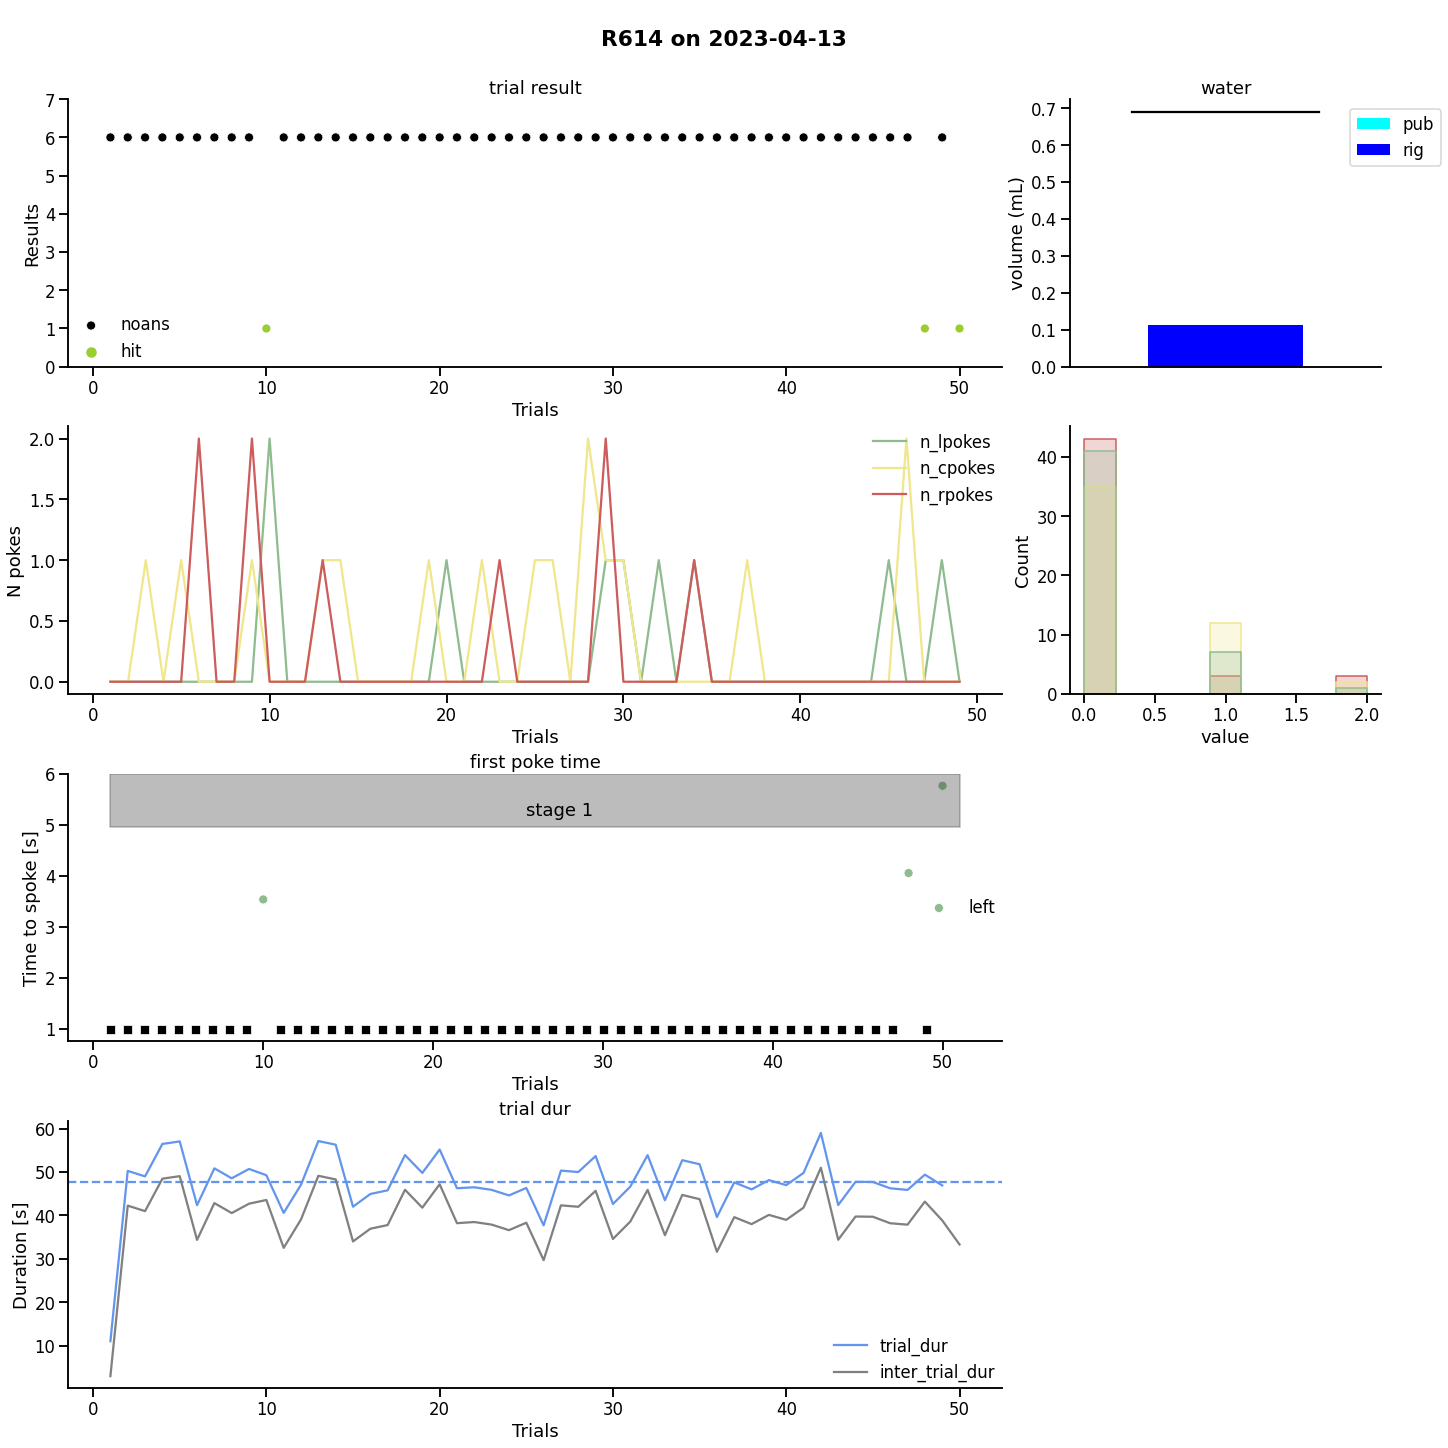

In [187]:

layout="""
    AAAB
    CCCD
    EEE.
    FFF.
    """
fig = plt.figure(constrained_layout=True,figsize=(20,20))
plt.suptitle(f"\n{animal_id} on {sub_df.date[0]}\n", fontweight="semibold")
ax_dict = fig.subplot_mosaic(layout) #ax to plot to
# identify_axes(ax_dict) # prints the letter for id

plot_daily_results(sub_df,ax=ax_dict['A'], title="trial result")
plot_daily_water(sub_df, ax_dict['B'], title= "water")
plot_daily_npokes(sub_df,ax_dict['C'], plot_stage_info=False)
plot_daily_first_spoke(sub_df, ax_dict['E'], title="first poke time",plot_stage_info=True)
plot_daily_trial_dur(sub_df, ax_dict['F'], title="trial dur")


sns.histplot(data=pokes_df, x="value",
        palette=["darkseagreen", "khaki", "indianred"],
        hue="variable",
        element="step", ax=ax_dict['D'], legend=False)

